In [1]:
import cv2,os,math
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,roc_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  4
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 1. Read data

In [3]:
# Data(x)
untreaded_train=np.load("../Classification/results2022/untreaded_train.npy",allow_pickle=True)[:3000]
# untreaded_train=np.load("../Classification/results2022/untreaded_train_all.npy",allow_pickle=True)[:10000]
VPAtreaded_train=np.load("../Classification/results2022/VPAtreaded_train.npy",allow_pickle=True)[:3000]
untreaded_test=np.load("../Classification/results2022/untreaded_test.npy",allow_pickle=True)
VPAtreaded_test=np.load("../Classification/results2022/VPAtreaded_test.npy",allow_pickle=True)

print("untreaded_train.shape:", untreaded_train.shape)
print("VPAtreaded_train.shape:", VPAtreaded_train.shape)
print("untreaded_test.shape:", untreaded_test.shape)
print("VPAtreaded_test.shape:", VPAtreaded_test.shape)

# Label(y)
y_untreaded_train = torch.zeros(len(untreaded_train), dtype=torch.int64)
y_VPAtreaded_train = torch.ones(len(VPAtreaded_train), dtype=torch.int64)
y_untreaded_test = torch.zeros(len(untreaded_test), dtype=torch.int64)
y_VPAtreaded_test = torch.ones(len(VPAtreaded_test), dtype=torch.int64)

# concatenate x and y
X_train, X_test = np.concatenate((untreaded_train, VPAtreaded_train), axis = 0), np.concatenate((untreaded_test, VPAtreaded_test), axis = 0)
y_train, y_test = torch.cat((y_untreaded_train, y_VPAtreaded_train), 0), torch.cat((y_untreaded_test, y_VPAtreaded_test), 0)

untreaded_train.shape: (3000, 100, 100, 3)
VPAtreaded_train.shape: (3000, 100, 100, 3)
untreaded_test.shape: (210, 100, 100, 3)
VPAtreaded_test.shape: (210, 100, 100, 3)


# 2. Data processing 

In [4]:
class cell_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.transform(self.x[idx]), F.one_hot(self.y[idx],num_classes=2).to(torch.float)

# trainval_data = cell_dataset(X_train, y_train)
train_data = cell_dataset(X_train, y_train)
val_data = cell_dataset(X_test, y_test)

batch_size = 32
# val_size = int(len(trainval_data)*0.2)
# train_size = len(trainval_data) - val_size

# train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

# 3. Build Model

In [36]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()
        self.resnet = models.resnet18(weights=True)
        self.resnet.layer3 = nn.Sequential()
        self.resnet.layer4 = nn.Sequential()
        self.resnet.fc = nn.Linear(128, 2)
#         self.resnet.load_state_dict(torch.load(""))
#         self.resnet = torch.load("../Classification/model/SelfResnet9C1F_220920.pkl")
        
    def forward(self, x):
        x = self.resnet(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [37]:
model = ResNet().to(device)

/home/acd13264yb/python7_env/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
ngpu = 4
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))

In [17]:
image_size = 100
test_input = torch.ones(1,3,image_size,image_size).to(device)
print(model(test_input).size())
print(model(test_input))

torch.Size([1, 2])
tensor([[0.5107, 0.4893]], device='cuda:0', grad_fn=<GatherBackward>)


In [18]:
# model = torch.load("Feactor.pkl")

# #Freeze model weights
# for param in model.parameters():
#     param.requires_grad = True
# for param in model.fc.parameters():
#     param.requires_grad = True

In [19]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
loss_function = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 定义优化器
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # 定义衰减策略

In [20]:
losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

In [21]:
n_epochs = 100
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []
    # Train
    optimizer.step()
    model.train()
    n_train = 0
    acc_train = 0
    for x, y in dataloader_train:
        n_train += y.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        acc_train += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    model.eval()
    n_val = 0
    acc_val = 0
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        acc_val += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_valid.append(loss.tolist())
    scheduler.step()
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_valid))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'
          .format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

EPOCH: 0, Train [Loss: 0.449, Accuracy: 0.788], Valid [Loss: 1.142, Accuracy: 0.548]
EPOCH: 1, Train [Loss: 0.428, Accuracy: 0.807], Valid [Loss: 0.356, Accuracy: 0.860]
EPOCH: 2, Train [Loss: 0.405, Accuracy: 0.820], Valid [Loss: 0.391, Accuracy: 0.833]
EPOCH: 3, Train [Loss: 0.392, Accuracy: 0.824], Valid [Loss: 0.372, Accuracy: 0.848]
EPOCH: 4, Train [Loss: 0.381, Accuracy: 0.827], Valid [Loss: 0.382, Accuracy: 0.817]
EPOCH: 5, Train [Loss: 0.369, Accuracy: 0.833], Valid [Loss: 0.342, Accuracy: 0.857]
EPOCH: 6, Train [Loss: 0.364, Accuracy: 0.843], Valid [Loss: 0.350, Accuracy: 0.855]
EPOCH: 7, Train [Loss: 0.347, Accuracy: 0.848], Valid [Loss: 0.409, Accuracy: 0.831]
EPOCH: 8, Train [Loss: 0.330, Accuracy: 0.860], Valid [Loss: 0.413, Accuracy: 0.812]
EPOCH: 9, Train [Loss: 0.312, Accuracy: 0.869], Valid [Loss: 0.750, Accuracy: 0.698]
EPOCH: 10, Train [Loss: 0.310, Accuracy: 0.865], Valid [Loss: 0.268, Accuracy: 0.876]
EPOCH: 11, Train [Loss: 0.294, Accuracy: 0.874], Valid [Loss: 0.

EPOCH: 96, Train [Loss: 0.008, Accuracy: 0.998], Valid [Loss: 0.331, Accuracy: 0.950]
EPOCH: 97, Train [Loss: 0.003, Accuracy: 0.999], Valid [Loss: 0.348, Accuracy: 0.957]
EPOCH: 98, Train [Loss: 0.004, Accuracy: 0.999], Valid [Loss: 0.421, Accuracy: 0.938]
EPOCH: 99, Train [Loss: 0.002, Accuracy: 0.999], Valid [Loss: 0.330, Accuracy: 0.952]


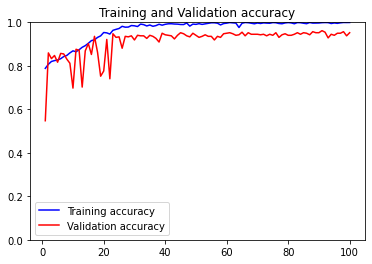

<Figure size 432x288 with 0 Axes>

In [22]:
# train processing plot
n_epochs = 100
epochs=range(1,n_epochs+1)
plt.ylim(0,1.0)
plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

total_test: 420
accuracy_score: 0.952
precision_score: 0.940
roc_auc_score: 0.984


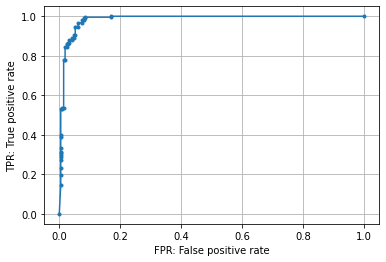

In [24]:
# Test
X = X_test
y = y_test
y_pred = []
out_pred = []
total = X.shape[0]

model.eval()
for n in range(total):
    img = X[n]
    label = y[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    output = model(input_tensor)
    pred = output.argmax(1).cpu().item()
    out_pred.append(output[0][1].item())
    y_pred.append(pred)

y_pred = np.array(y_pred)
out_pred = np.array(out_pred)
print("total_test: {:}" .format(total))
print('accuracy_score: {:.3f}'.format(accuracy_score(y,y_pred)))
print('precision_score: {:.3f}'.format(precision_score(y,y_pred)))
print('roc_auc_score: {:.3f}'.format(roc_auc_score(y, out_pred)))

fpr, tpr, thresholds = roc_curve(y, out_pred,drop_intermediate=True)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 4. Feature map

In [25]:
# 定义钩子函数，获取指定层名称的特征
feature_activation = {} # 保存获取的输出
def get_activation(name):
    def hook(model, input, output):
        feature_activation[name] = output.detach()
    return hook

for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))
    print(name)


module
module.resnet
module.resnet.conv1
module.resnet.bn1
module.resnet.relu
module.resnet.maxpool
module.resnet.layer1
module.resnet.layer1.0
module.resnet.layer1.0.conv1
module.resnet.layer1.0.bn1
module.resnet.layer1.0.relu
module.resnet.layer1.0.conv2
module.resnet.layer1.0.bn2
module.resnet.layer1.1
module.resnet.layer1.1.conv1
module.resnet.layer1.1.bn1
module.resnet.layer1.1.relu
module.resnet.layer1.1.conv2
module.resnet.layer1.1.bn2
module.resnet.layer2
module.resnet.layer2.0
module.resnet.layer2.0.conv1
module.resnet.layer2.0.bn1
module.resnet.layer2.0.relu
module.resnet.layer2.0.conv2
module.resnet.layer2.0.bn2
module.resnet.layer2.0.downsample
module.resnet.layer2.0.downsample.0
module.resnet.layer2.0.downsample.1
module.resnet.layer2.1
module.resnet.layer2.1.conv1
module.resnet.layer2.1.bn1
module.resnet.layer2.1.relu
module.resnet.layer2.1.conv2
module.resnet.layer2.1.bn2
module.resnet.layer3
module.resnet.layer4
module.resnet.avgpool
module.resnet.fc
avgpool


In [26]:
i = 1
img = train_data[i][0].permute(1,2,0).numpy()
label = train_data[i][1][1]
input_tensor = train_data[i][0].unsqueeze(0).to(device)
output = model(input_tensor)
y = output.argmax(1).cpu().item()
print("y is",y , "; pre is", label.item(), "=>",y==label.item())

y is 0 ; pre is 0.0 => True


max: 0.133, min: -0.441
max: 1.000, min: 0.000


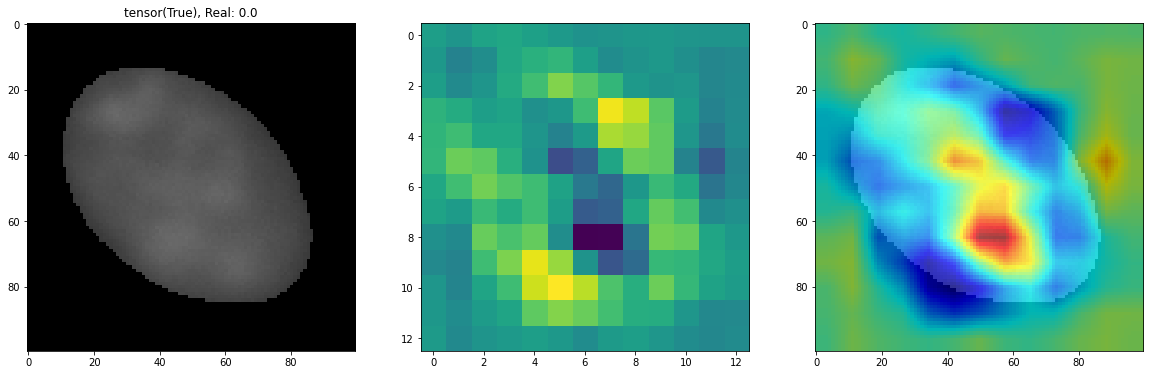

In [27]:
key = "module.resnet.layer2.1.conv2"
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title(str(y==label)+", Real: "+str(label.item()))
plt.imshow(img)

bn = feature_activation[key].cpu()[0].mean(axis=0)
print('max: {:.3f}, min: {:.3f}'.format(torch.amax(bn),torch.amin(bn)))
bn = cv2.normalize(bn.numpy(), None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
print('max: {:.3f}, min: {:.3f}'.format(np.amax(bn),np.amin(bn)))
plt.subplot(1,3,2)
plt.imshow(bn)

plt.subplot(1,3,3)
bn = cv2.resize(bn,(100,100))
cam = show_cam_on_image(img, bn)
plt.imshow(cam)

In [179]:
# num = feature_activation[key].cpu()[0].shape[0]
# num = 10
# for i in range(num):
#     plt.figure(figsize=(10,10))
#     plt.subplot(1,3,1)
#     plt.title(y==label)
#     plt.imshow(img/np.amax(img))
    
#     bn = feature_activation[key].cpu()[0][i]
#     bn = cv2.normalize(bn.numpy(), None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
#     plt.subplot(1,3,2)
#     plt.title(key)
#     plt.imshow(bn)
    
#     plt.subplot(1,3,3)
#     plt.axis("off")
#     bn = cv2.merge([bn,bn,bn])
#     cam = show_cam_on_image(img, bn)
#     plt.imshow(cam)

In [174]:
for key in feature_activation:
    bn = feature_activation[key].cpu()
    print(key," : ",bn.shape)

module.resnet.conv1  :  torch.Size([1, 64, 50, 50])
module.resnet.bn1  :  torch.Size([1, 64, 50, 50])
module.resnet.relu  :  torch.Size([1, 64, 50, 50])
module.resnet.maxpool  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1.0.conv1  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1.0.bn1  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1.0.relu  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1.0.conv2  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1.0.bn2  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1.0  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1.1.conv1  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1.1.bn1  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1.1.relu  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1.1.conv2  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1.1.bn2  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1.1  :  torch.Size([1, 64, 25, 25])
module.resnet.layer1  :  torch.Size([1, 64, 25, 25])
module.resnet.layer2.0.conv1  

# 5. GradCAM

In [28]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,deprocess_image,preprocess_image

def gradcams(model,input_tensor,target_layers,imgpad,optioncam):
    # GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
    if optioncam=="GradCAM":
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="ScoreCAM":
        cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="GradCAMPlusPlus":
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="AblationCAM":
        cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="XGradCAM":
        cam = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="EigenCAM":
        cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="FullGrad":
        cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
    else:
        return print("your option is not support")
    # Note: input_tensor can be a batch tensor with several images!
    # If None, returns the map for the highest scoring category. 
    # Otherwise, targets the requested index. target_index = 1
    targets = None
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#     grayscale_cam = cam(input_tensor=input_tensor,targets=targets,aug_smooth=True,eigen_smooth=True)
    grayscale_cam = cam(input_tensor, targets)[0]
    # In this example grayscale_cam has only one image in the batch:
    visualization = show_cam_on_image(imgpad, grayscale_cam, use_rgb=True)
    
    # Guided-GradCAM
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, targets)
#     if np.amax(gb)!=0:
#         gb = np.maximum(gb,0)*(1/np.amax(gb))
    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = cam_mask * gb
    
    return visualization,gb,cam_gb,cam_mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(True)


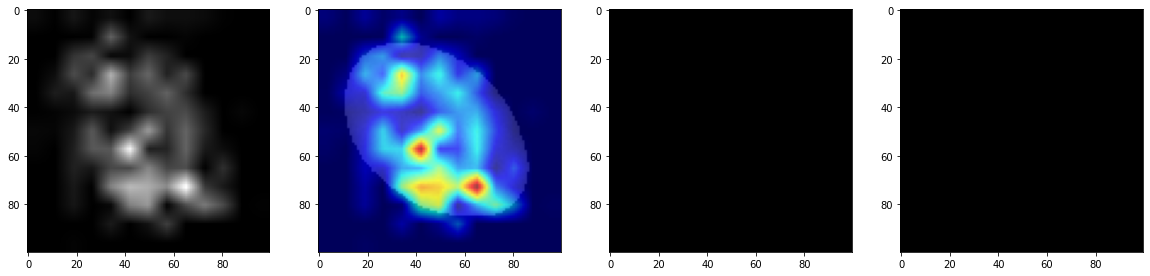

In [29]:
target_layers = [model.module.resnet.layer2[0]]
# cam's option: GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, ScoreCAM, FullGrad
optioncam = "GradCAM"
visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
print(y==label)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(cam)
plt.subplot(1,4,2)
plt.imshow(visualization)
plt.subplot(1,4,3)
plt.imshow(gb)
plt.subplot(1,4,4)
plt.imshow(cam_gb)

# 99. save model

In [44]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model.module.state_dict(),"ResNet9C_221204.pkl")